Approximate the artist embeddings using [this](http://yifanhu.net/PUB/cf.pdf) method.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seed_regression
from tqdm import tqdm

SUBSETS = ["test", "train", "val"]
MODEL_IDS = ["929", "962"]  # fact and class, respectively
ALBUM_TRACK_TSV = "../data/multi2de_dataset.tsv"
ALBUM_IDX_DICT = {"test": "../data/items_index_test_multi2deA2.tsv",
                  "train": "../data/items_index_train_multi2deA2.tsv",
                  "val": "../data/items_index_val_multi2deA2.tsv"}

%matplotlib inline

In [2]:
def load_all_embeds(model_id):
    """Loads all embeddings for a given model id"""
    track_ids = []
    for i, subset in enumerate(SUBSETS):
        tracks_df = pd.read_csv("../data/items_index_{}_model_{}-pred_16_multi2deT.tsv".format(
            subset, model_id), sep="\t", header=None)
        track_ids += tracks_df[0].tolist()
        subset_data = np.load("../data/X_{}_model_{}-pred_16_multi2deT.npy".format(subset, model_id))
        if i == 0:
            data = subset_data
        else:
            data = np.concatenate((data, subset_data))
    assert data.shape[0] == len(track_ids)
    return np.asarray(data, dtype=np.float64), track_ids

In [ ]:
# Read global mapping dataframe
map_df = pd.read_csv(ALBUM_TRACK_TSV, sep="\t")

# For each model
missing_tracks = []
str_output = ""
for model in MODEL_IDS:
    print("Computing model:", model)
    str_output += model + '\n'
    
    # Load all data and precompute factors matrix
    Y, track_ids = load_all_embeds(MODEL_IDS[1])
    YtY = Y.T.dot(Y)

    # For each subset
    for key in ALBUM_IDX_DICT.keys():
        print("Computing subset:", key)
        str_output += key + '\n'
        
        # Read Album ids for the given subset
        subset_album_ids = pd.read_csv(ALBUM_IDX_DICT[key], sep="\t", header=None)[0].tolist()
        album_embeds = []

        # For all albums in the subset
        for album_id in tqdm(subset_album_ids):
            album_track_ids = map_df[map_df["amazon_product_id"] == album_id]["msd_track_id"].tolist()

            # Get indeces for each track inside this album (each with weight of 1)
            song_weights = np.ones(len(album_track_ids))
            song_indices = []
            for album_track_id in album_track_ids:
                try:
                    song_indices.append(track_ids.index(album_track_id))
                except ValueError:
                    missing_tracks.append(album_track_id)
                    print("Track: {} doesn't exist".format(album_track_id))

            # Compute embedding
            A, b = seed_regression.get_seed_embedding(Y, YtY, song_indices, song_weights, alpha=32000.0, lambda_=0.95)
            album_embeds.append(np.linalg.solve(A, b).squeeze())
            str_output += album_id + '\n'
            with open("output.txt", "w") as fw:
                fw.write(str_output)

        # Store these album embeddings for the current subset and model
        np.save("album_embeds_{}_model_{}.npy".format(key, model), np.asarray(album_embeds))

Computing model: 929



  0%|          | 0/3147 [00:00<?, ?it/s]

Computing subset: test



  0%|          | 3/3147 [00:04<1:11:43,  1.37s/it]

Track: TRHGYBR128F930BF6D doesn't exist



  2%|▏         | 576/25175 [14:15<10:26:42,  1.53s/it]

Track: TRWRJQW128F4276D54 doesn't exist
Track: TRTVWRI128F4276D37 doesn't exist
Track: TRCQKIH128F4276D4D doesn't exist


  3%|▎         | 668/25175 [16:24<9:46:13,  1.44s/it] 

In [6]:
map_df.head()

,amazon_product_id,release_group_mbid,msd_track_id,recording_mbid,artist_mbid,genres
0,B000038ICJ,09334082-a6e0-367a-b17e-a587190bb1d2,TRDHBUB128F1490F94,9063e0fe-dbdd-4d53-ab18-942d9b822fda,25e0497c-faa4-4765-b232-baa20e5e35a7,"Pop Rap,Soul,Pop,R&B,Rap & Hip-Hop,Blues"
1,B000038ICJ,09334082-a6e0-367a-b17e-a587190bb1d2,TRVNRDZ128F148D455,f85b8e67-1845-496d-949b-071c48a94a1c,25e0497c-faa4-4765-b232-baa20e5e35a7,"Pop Rap,Soul,Pop,R&B,Rap & Hip-Hop,Blues"
2,B000038ICJ,09334082-a6e0-367a-b17e-a587190bb1d2,TRBBGFP128F148D448,e23c36a2-4168-4692-bd71-f0aebe1dfc19,25e0497c-faa4-4765-b232-baa20e5e35a7,"Pop Rap,Soul,Pop,R&B,Rap & Hip-Hop,Blues"
3,B000038ICJ,09334082-a6e0-367a-b17e-a587190bb1d2,TRNZFCL128F148D444,9af26529-ea96-49dd-b62a-94a1bad4fada,25e0497c-faa4-4765-b232-baa20e5e35a7,"Pop Rap,Soul,Pop,R&B,Rap & Hip-Hop,Blues"
4,B000038ICJ,09334082-a6e0-367a-b17e-a587190bb1d2,TRAZGRG128F148D44C,c60a2ded-ba40-4c3b-9222-e510078d090e,25e0497c-faa4-4765-b232-baa20e5e35a7,"Pop Rap,Soul,Pop,R&B,Rap & Hip-Hop,Blues"


280412.547073 0.0
17.4926376343 0.0


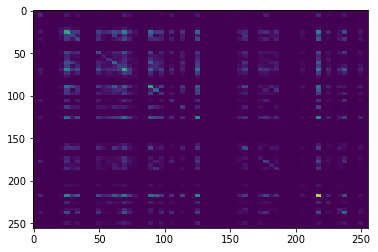

In [5]:
plt.imshow(YtY, interpolation="nearest", aspect="auto", cmap="viridis")
print(YtY.max(), YtY.min())
print(Y.max(), Y.min())

1236859.60491 0.0
519626.126396 0.0


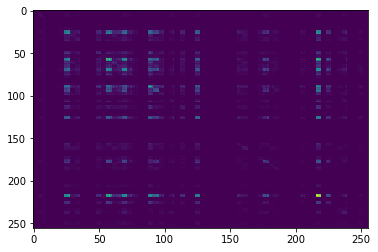

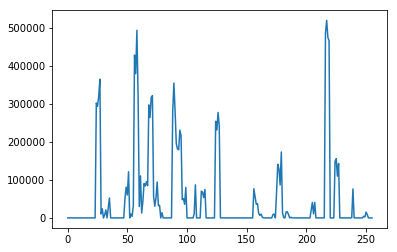

In [19]:
plt.imshow(A, interpolation="nearest", aspect="auto", cmap="viridis")
print(A.max(), A.min())
print(b.max(), b.min())
plt.figure()
plt.plot(b)

/home/onieto/local/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1821: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


inf

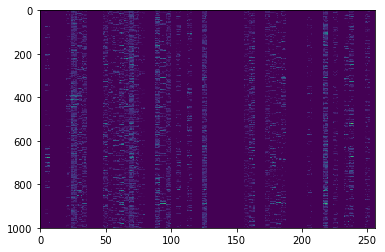

In [29]:
plt.imshow(Y[:1000], interpolation="nearest", aspect="auto", cmap="viridis")
np.linalg.det(A)

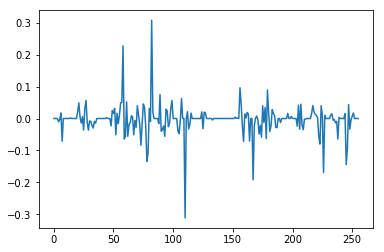

In [36]:
plt.plot(album_embed)